In [2]:
! rm -r -f amalearn

In [3]:
! unzip amalearn-0.1.zip

Archive:  amalearn-0.1.zip
   creating: amalearn/
   creating: amalearn/.git/
  inflating: amalearn/.git/description  
   creating: amalearn/.git/hooks/
  inflating: amalearn/.git/hooks/applypatch-msg.sample  
  inflating: amalearn/.git/hooks/commit-msg.sample  
  inflating: amalearn/.git/hooks/fsmonitor-watchman.sample  
  inflating: amalearn/.git/hooks/post-update.sample  
  inflating: amalearn/.git/hooks/pre-applypatch.sample  
  inflating: amalearn/.git/hooks/pre-commit.sample  
  inflating: amalearn/.git/hooks/pre-merge-commit.sample  
  inflating: amalearn/.git/hooks/pre-push.sample  
  inflating: amalearn/.git/hooks/pre-rebase.sample  
  inflating: amalearn/.git/hooks/pre-receive.sample  
  inflating: amalearn/.git/hooks/prepare-commit-msg.sample  
  inflating: amalearn/.git/hooks/update.sample  
   creating: amalearn/.git/info/
  inflating: amalearn/.git/info/exclude  
   creating: amalearn/.git/refs/
   creating: amalearn/.git/refs/heads/
  inflating: amalearn/.git/refs/heads/

In [1]:
! pip install -e ./amalearn

Obtaining file:///content/amalearn
  Found existing installation: amalearn 0.1
    Can't uninstall 'amalearn'. No files were found to uninstall.
  Running setup.py develop for amalearn


###action reward

In [2]:
from amalearn.reward import RewardBase
import numpy as np

class PathReward(RewardBase):
    def __init__(self, means, stds, pis):
        super(PathReward, self).__init__()
        self.means = means
        self.stds = stds
        self.pis = pis

    def get_reward(self):
        r = 0
        for i in range(len(self.means)):
          temp = np.random.normal(loc=self.means[i], scale=np.sqrt(self.stds[i]))
          if temp >= 0:
            r += temp
        for p in self.pis:
          l = np.random.random()
          if l < p:
            r += 10
        return -1*r

###EpsilonGreedyAgent

In [3]:
import operator
from amalearn.agent import AgentBase

class EpsilonGreedyAgent(AgentBase):
    def __init__(self, id, environment, lr=None, eps=None):
        super(EpsilonGreedyAgent, self).__init__(id, environment)
        self.act_num = self.environment.available_actions()
        self.m0 = 0      # mean
        self.actions_estimation = dict(zip(range(self.act_num), [self.m0 for i in range(self.act_num)]))
        self.length = 0
        self.trial = {}
        self.lr = lr
        self.eps = eps
        # print(self.actions_estimation)
    
    def reset(self):
        self.actions_estimation = dict(zip(range(self.act_num), [self.m0 for i in range(self.act_num)]))
        self.length = 0
        self.trial = {}
        # print(self.actions_estimation)

    def u(self, r):
        return r

    def update_estimation(self, action, r):
        u = self.u(r)
        if self.lr is None:
          self.actions_estimation[action] = \
            ((self.actions_estimation[action]*self.length)+u)/float(self.length+1)
        else:
          self.actions_estimation[action] = ((1-self.lr)*self.actions_estimation[action])+(u*self.lr)

        self.trial[self.length] = (action, u)
        self.length += 1
        # print(self.actions_estimation)

    def select_action(self):
        p = np.random.random()
        eps = self.eps
        if self.eps is None:
          eps = (1/float(self.length+1))-((1/float(self.length+1))/float(self.act_num))
        best_q_index = max(self.actions_estimation.items(), key=operator.itemgetter(1))[0]
        candid = [i for i in range(self.act_num) if i != best_q_index]
        if p < eps: 
          j = np.random.choice(len(candid))
          best_q_index = candid[j]
        return best_q_index

    def get_stat(self):
        return self.trial

    def get_best_action(self):
        best_q_index = max(self.actions_estimation.items(), key=operator.itemgetter(1))[0]
        return (best_q_index, self.actions_estimation[best_q_index])

    def take_action(self) -> (object, float, bool, object):
        action = self.select_action()
        obs, r, d, i = self.environment.step(action)
        self.update_estimation(action, r)
        print(obs, r, self.u(r), d, i)
        self.environment.render()
        return obs, r, self.u(r), d, i

In [4]:
from amalearn.environment import MutliArmedBanditEnvironment

pis = [0.1, 0.06, 0.15, 0.5, 0.1, 0.15, 0.65, 0.12, 0.2, 0.05, 0.45]
mean_map = {'b':8, 'g':4, 'o':3}
std_map = {'b':4.2, 'g':4, 'o':9.5}

link_color = {(0,1):'g', (0,3):'g', (1,5):'g', (3,5):'g', (4,6):'g', (4,7):'g',\
              (6,8):'g', (6,9):'g', (7,11):'g', (7,10):'g', (10,12):'g', (0,4):'o',\
              (2,6):'o', (2,7):'o', (3,6):'o', (4,5):'o', (5,8):'o', (5,9):'o',\
              (7,8):'o', (7,9):'o', (9,12):'o', (11,12):'o', (0,2):'b', (1,6):'b',\
              (1,7):'b', (2,5):'b', (3,7):'b', (5,10):'b', (5,11):'b', (6,10):'b',\
              (6,11):'b', (8,12):'b'}


pathes_t5 = [[0,1,5], [0,2,5], [0,3,5], [0,4,5]]
pathes_t6 = [[0,1,6], [0,2,6], [0,3,6], [0,4,6]]
pathes_t7 = [[0,1,7], [0,2,7], [0,3,7], [0,4,7]]

pathes_f5 = [[5,8,12], [5,9,12], [5,10,12], [5,11,12]]
pathes_f6 = [[6,8,12], [6,9,12], [6,10,12], [6,11,12]]
pathes_f7 = [[7,8,12], [7,9,12], [7,10,12], [7,11,12]]

pathes = [pathes_t5, pathes_t6, pathes_t7, pathes_f5, pathes_f6, pathes_f7]

def run(pathes, epsilon=None):

  datas = []
  qsum = [0 for i in range(len(pathes))]
  astar = [0 for i in range(len(pathes))]

  k = 0

  for p in pathes:
    rewards = None
    if k <3:
      print(p)
      rewards = [PathReward([mean_map[link_color[(i[j],i[j+1])]] for j in range(len(i)-1)],\
                          [std_map[link_color[(i[j],i[j+1])]] for j in range(len(i)-1)],\
                          [pis[i[j]-1] for j in range(1,len(i))]) for i in p]
    if k >= 3:
      rewards = [PathReward([mean_map[link_color[(i[j],i[j+1])]] for j in range(len(i)-1)],\
                        [std_map[link_color[(i[j],i[j+1])]] for j in range(len(i)-1)],\
                        [pis[i[j]-1] for j in range(1,len(i)-1)]) for i in p]
    env = MutliArmedBanditEnvironment(rewards, 5000, '1')
    agent = EpsilonGreedyAgent('1', env, lr=0.02, eps=epsilon)
    qsum_t = 0
    data = []
    for run in range(50):
      for step in range(1500):
          agent.take_action()
      data.append(agent.get_stat())
      qsum[k] += agent.get_best_action()[1]
      astar[k] = agent.get_best_action()[0]
      env.reset()
      agent.reset()
    qsum[k] /= 50
    datas.append(data)
    k+=1
  print(qsum)
  return datas, qsum, astar

In [15]:
datas, qsum, astar = run(pathes)

Streaming output truncated to the last 5000 lines.
501:	action=2
{} -10.845111367081413 -10.845111367081413 False {}
502:	action=2
{} -9.766700129920794 -9.766700129920794 False {}
503:	action=2
{} -6.652993502749429 -6.652993502749429 False {}
504:	action=2
{} -5.6148464518821815 -5.6148464518821815 False {}
505:	action=2
{} -13.694312876221943 -13.694312876221943 False {}
506:	action=2
{} -9.889115822843326 -9.889115822843326 False {}
507:	action=2
{} -10.007607351163236 -10.007607351163236 False {}
508:	action=2
{} -5.980792973771384 -5.980792973771384 False {}
509:	action=2
{} -11.343801065303463 -11.343801065303463 False {}
510:	action=2
{} -5.752869131769819 -5.752869131769819 False {}
511:	action=2
{} -7.169081111609946 -7.169081111609946 False {}
512:	action=2
{} -6.058420751491493 -6.058420751491493 False {}
513:	action=2
{} -10.802255992196798 -10.802255992196798 False {}
514:	action=2
{} -11.009922108437925 -11.009922108437925 False {}
515:	action=2
{} -8.667746700709904 -8.

In [11]:
def find_best_path(qsum, astar, pathes):
  last_pl = []
  last_p = []
  for i in range(len(qsum)-3):
    last_pl.append(qsum[i]+qsum[i+3])
    temp = list(pathes[i][astar[i]])
    temp.extend(list(pathes[i+3][astar[i+3]]))
    last_p.append(temp)

  return list(set(last_p[np.argmax(np.array(last_pl))])), -1*np.max(np.array(last_pl))

In [181]:
p, l = find_best_path(qsum, astar, pathes)
print('best path: ', p, ' mean latency:', l, ' actions: ', 6*1500 )

best path:  [0, 1, 5, 9, 12]  mean latency: 18.760595506353027  actions:  9000


In [12]:
import matplotlib.pyplot as plt

def draw_list(data, xlabel, ylabel, data_label):
  plt.plot(range(len(data)), data, label=data_label)
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  plt.grid()
  plt.legend()

def draw_lists_compare(data1, data2, xlabel, ylabel, data1_label, data2_label):
  plt.plot(range(len(data1)), data1, label=data1_label)
  plt.plot(range(len(data2)), data2, label=data2_label)
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  plt.grid()
  plt.legend()

In [13]:
def regret_per_run(data, best_action_mean, h):
    sum = 0
    for i in data.keys():
      if i > (h-1):
        break
      sum += data[i][1]
    return h*best_action_mean-sum

def regret(data, max_mean):
  regret_list = []
  for run in data:
    run_regret = []
    for j in range(len(run.keys())):
      run_regret.append(regret_per_run(run, max_mean, j+1))
    regret_list.append(run_regret)

  return regret_list

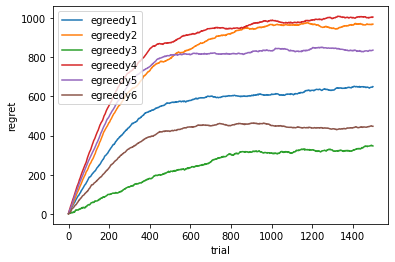

In [173]:
for i in range(len(qsum)):
  mean_regret = np.mean(np.array(regret(datas[i], qsum[i])), axis=0)
  # print(np.argmin(np.abs(np.diff(mean_regret[1000:])))+1000)
  draw_list(mean_regret, 'trial', 'regret', 'egreedy'+str(i+1))

In [185]:
epses = [None, 0.2, 0.8]

best_pathes = []
best_delay = []

draw_dict = {}

p, l = find_best_path(qsum, astar, pathes)
best_delay.append(l)
best_pathes.append(p)
for i in range(len(qsum)):
    mean_regret = np.mean(np.array(regret(datas[i], qsum[i])), axis=0)
    draw_dict[(i,epses[0])] = mean_regret


for eps in epses[1:]:
  datas, qsum, astar = run(pathes,eps)
  p, l = find_best_path(qsum, astar, pathes)
  best_delay.append(l)
  best_pathes.append(p)
  for i in range(len(qsum)):
    mean_regret = np.mean(np.array(regret(datas[i], qsum[i])), axis=0)
    draw_dict[(i,eps)] = mean_regret

Streaming output truncated to the last 5000 lines.
1456:	action=0
{} -21.429889070590082 -21.429889070590082 False {}
1457:	action=3
{} -11.366058077006683 -11.366058077006683 False {}
1458:	action=3
{} -24.294404408353675 -24.294404408353675 False {}
1459:	action=3
{} -6.206501984303813 -6.206501984303813 False {}
1460:	action=0
{} -14.618929164223106 -14.618929164223106 False {}
1461:	action=3
{} -8.164405090869181 -8.164405090869181 False {}
1462:	action=3
{} 0 0 False {}
1463:	action=1
{} -18.69573671449783 -18.69573671449783 False {}
1464:	action=2
{} -10.65591038741871 -10.65591038741871 False {}
1465:	action=0
{} -8.563866325218802 -8.563866325218802 False {}
1466:	action=3
{} -13.8059098018488 -13.8059098018488 False {}
1467:	action=0
{} -13.97001825089431 -13.97001825089431 False {}
1468:	action=1
{} -13.031735717963482 -13.031735717963482 False {}
1469:	action=3
{} -10.105980760343392 -10.105980760343392 False {}
1470:	action=1
{} -8.427320433235058 -8.427320433235058 False {

In [186]:
for i in range(len(epses)):
  print('eps: ', epses[i], ' best path: ', best_pathes[i], ' mean latency:', best_delay[i], ' actions: ', 6*1500 )

eps:  None  best path:  [0, 1, 5, 9, 12]  mean latency: 18.760595506353027  actions:  9000
eps:  0.2  best path:  [0, 1, 5, 9, 12]  mean latency: 18.785485644864153  actions:  9000
eps:  0.8  best path:  [0, 3, 5, 9, 12]  mean latency: 18.43289619229058  actions:  9000


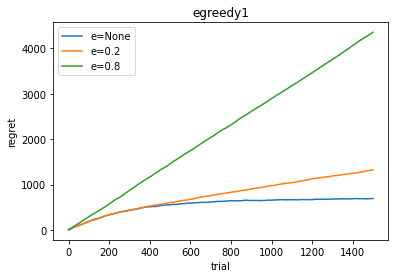

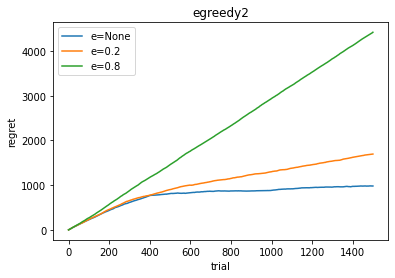

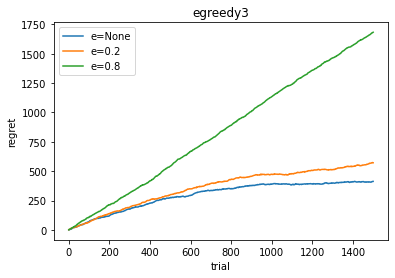

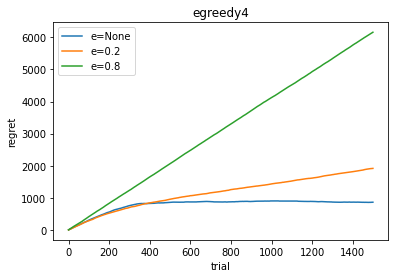

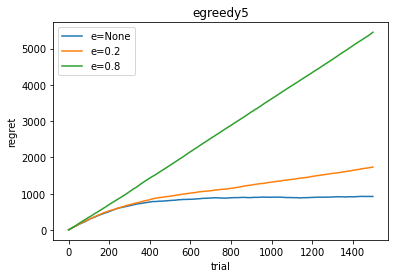

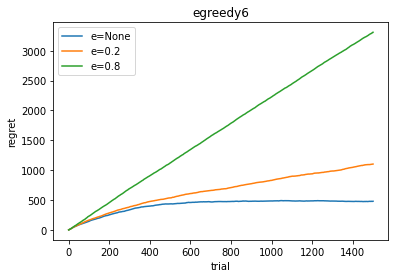

In [187]:
for i in range(len(pathes)):
  for e in epses:
    draw_list(draw_dict[(i,e)], 'trial', 'regret', 'e='+str(e))
  plt.title('egreedy'+str(i+1))
  plt.grid()
  plt.show()

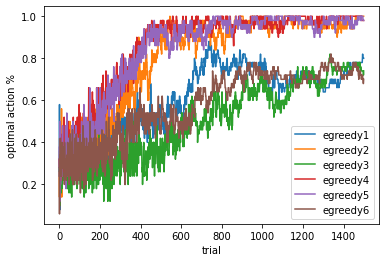

In [56]:
k = 0
for i in astar:
  opta = i
  opta_per = optimal_action_ratio(datas[k], opta)
  draw_list(opta_per, 'trial', 'optimal action %', 'egreedy'+str(k+1))
  k+=1

###gradient method agent

In [7]:
import operator
from amalearn.agent import AgentBase

class GradientMethodAgent(AgentBase):
    def __init__(self, id, environment, lr=0.02):
        super(GradientMethodAgent, self).__init__(id, environment)
        self.act_num = self.environment.available_actions()
        self.m0 = 0      # mean
        self.actions_estimation = dict(zip(range(self.act_num), [0 for i in range(self.act_num)]))
        self.h = [0 for i in range(self.act_num)]
        self.policy = [1/float(self.act_num) for i in range(self.act_num)]
        self.length = 0
        self.trial = {}
        self.lr = lr
    
    def reset(self):
        self.m0 = 0 
        self.actions_estimation = dict(zip(range(self.act_num), [0 for i in range(self.act_num)]))
        self.h = [0 for i in range(self.act_num)]
        self.policy = [1/float(self.act_num) for i in range(self.act_num)]
        self.length = 0
        self.trial = {}

    def u(self, r):
        return r

    def proba(self, action):
        sum = 0
        for i in range(self.act_num):
          sum += np.exp(self.h[i])
        return np.exp(self.h[action])/sum

    def softmax(self):
      for i in range(self.act_num):
        self.policy[i] = self.proba(i)

    def update_estimation(self, action, r):
        u = self.u(r)

        # self.actions_estimation[action] =\
        #   ((self.actions_estimation[action]*self.length)+u)/float(self.length+1)
        self.actions_estimation[action] = ((1-0.02)*self.actions_estimation[action])+(u*0.02)

        for i in range(self.act_num):
          if i == action:
            self.h[i] += self.lr*(u-self.m0)*(1-self.policy[i])
          else:
            self.h[i] -= self.lr*(u-self.m0)*self.policy[i]

        self.m0 = ((self.m0 * self.length)+u)/float(self.length+1)
        self.softmax()

        self.trial[self.length] = (action, u)
        self.length += 1
        # print(self.actions_estimation)

    def select_action(self):
        return np.random.choice(self.act_num, p=self.policy)

    def get_stat(self):
        return self.trial

    def get_best_action(self):
        # best_q_index = max(self.actions_estimation.items(), key=operator.itemgetter(1))[0]
        index = np.argmax(np.array(self.policy))
        return (index, self.actions_estimation[index])

    def take_action(self) -> (object, float, bool, object):
        action = self.select_action()
        obs, r, d, i = self.environment.step(action)
        self.update_estimation(action, r)
        print(obs, r, self.u(r), d, i)
        self.environment.render()
        return obs, r, self.u(r), d, i

In [8]:
def run_gradian(pathes, lr=0.01):

  datas = []
  qsum = [0 for i in range(len(pathes))]
  astar = [0 for i in range(len(pathes))]

  k = 0

  for p in pathes:
    rewards = None
    if k <3:
      print(p)
      rewards = [PathReward([mean_map[link_color[(i[j],i[j+1])]] for j in range(len(i)-1)],\
                          [std_map[link_color[(i[j],i[j+1])]] for j in range(len(i)-1)],\
                          [pis[i[j]-1] for j in range(1,len(i))]) for i in p]
    if k >= 3:
      rewards = [PathReward([mean_map[link_color[(i[j],i[j+1])]] for j in range(len(i)-1)],\
                        [std_map[link_color[(i[j],i[j+1])]] for j in range(len(i)-1)],\
                        [pis[i[j]-1] for j in range(1,len(i)-1)]) for i in p]
    env = MutliArmedBanditEnvironment(rewards, 5000, '1')
    agent = GradientMethodAgent('1', env, lr=lr)
    qsum_t = 0
    data = []
    for run in range(50):
      for step in range(2000):
          agent.take_action()
      data.append(agent.get_stat())
      qsum[k] += agent.get_best_action()[1]
      astar[k] = agent.get_best_action()[0]
      env.reset()
      agent.reset()
    qsum[k] /= 50
    datas.append(data)
    k+=1
  print(qsum)
  return datas, qsum, astar
  # return datas, astar

In [9]:
def optimal_action_ratio(data, opta):
  res = []
  trial_num = len(data[0].keys())

  for j in range(trial_num):
    temp = []
    for i in data:
      temp.append(i[j][0])
    res.append((temp.count(opta))/len(temp))
  
  return res

In [16]:
p, l = find_best_path(qsum, astar, pathes)
print('best path: ', p, ' mean latency:', l, ' actions: ', 6*1500 )

best path:  [0, 1, 5, 9, 12]  mean latency: 18.674826915557034  actions:  9000


In [22]:
datasg, qsumg, astarg = run_gradian(pathes)

Streaming output truncated to the last 5000 lines.
1501:	action=2
{} -6.075728389800891 -6.075728389800891 False {}
1502:	action=2
{} -12.2995170301812 -12.2995170301812 False {}
1503:	action=2
{} -15.061112020032565 -15.061112020032565 False {}
1504:	action=2
{} -9.329546305574867 -9.329546305574867 False {}
1505:	action=2
{} -9.469120399754459 -9.469120399754459 False {}
1506:	action=2
{} -5.671221902018598 -5.671221902018598 False {}
1507:	action=2
{} -14.35416950086638 -14.35416950086638 False {}
1508:	action=2
{} -7.335455470698516 -7.335455470698516 False {}
1509:	action=2
{} -9.742170151407898 -9.742170151407898 False {}
1510:	action=2
{} -7.0994858188844265 -7.0994858188844265 False {}
1511:	action=2
{} -18.5666765991563 -18.5666765991563 False {}
1512:	action=2
{} -14.15045423819357 -14.15045423819357 False {}
1513:	action=2
{} -9.463422368938959 -9.463422368938959 False {}
1514:	action=2
{} -16.023059149702767 -16.023059149702767 False {}
1515:	action=2
{} -17.404071091272243

In [23]:
print(astar)

[0, 2, 1, 1, 1, 2]


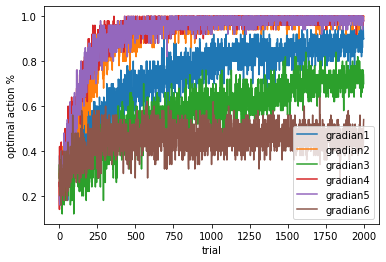

In [53]:
k = 0
for i in astarg:
  opta = i
  opta_per = optimal_action_ratio(datasg[k], opta)
  draw_list(opta_per, 'trial', 'optimal action %', 'gradian'+str(k+1))
  k+=1

In [49]:
p, l = find_best_path(qsumg, astarg, pathes)
print('best path: ', p, ' mean latency:', l, ' actions: ', 6*2000 )

best path:  [0, 1, 5, 9, 12]  mean latency: 18.73171717390435  actions:  12000


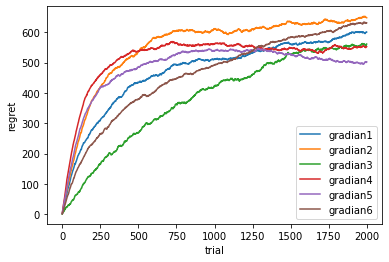

In [26]:
for i in range(len(qsumg)):
  mean_regret = np.mean(np.array(regret(datasg[i], qsumg[i])), axis=0)
  # print(np.argmin(np.abs(np.diff(mean_regret[1000:])))+1000)
  draw_list(mean_regret, 'trial', 'regret', 'gradian'+str(i+1))

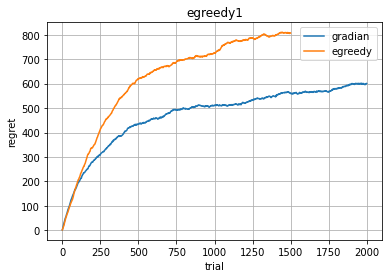

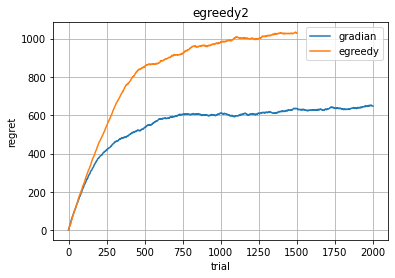

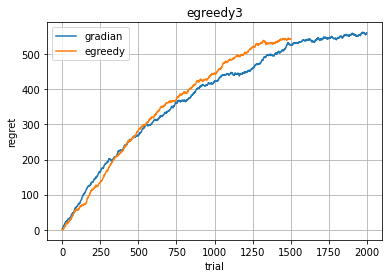

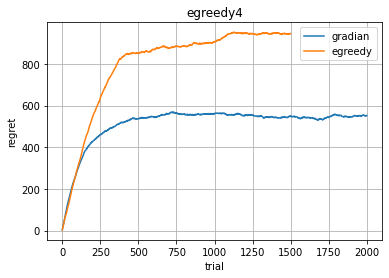

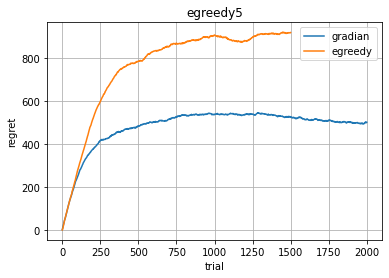

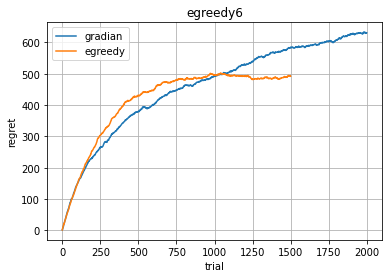

In [27]:
for i in range(len(pathes)):
  mean_regret = np.mean(np.array(regret(datasg[i], qsumg[i])), axis=0)
  draw_list(mean_regret, 'trial', 'regret', 'gradian')
  mean_regret = np.mean(np.array(regret(datas[i], qsum[i])), axis=0)
  draw_list(mean_regret, 'trial', 'regret', 'egreedy')
  plt.title('egreedy'+str(i+1))
  plt.grid()
  plt.show()

In [28]:
from Q2_agents import UCBAgent

class MyUCBAgent(UCBAgent):
  
  def __init__(self, id, c, environment):
    UCBAgent.__init__(self, id, c, environment)

  def u(self, r):
        return r 

  def update_estimation(self, action, r):
        u = self.u(r)
        # self.actions_estimation[action] = ((self.actions_estimation[action]*self.length)+u)/float(self.length+1)

        self.actions_estimation[action] = ((1-0.02)*self.actions_estimation[action])+(u*0.02)

        self.trial[self.length] = (action, u)
        self.act_count[action] += 1
        self.length += 1

In [29]:
def run_ucb(pathes, c=2):

  datas = []
  qsum = [0 for i in range(len(pathes))]
  astar = [0 for i in range(len(pathes))]

  k = 0

  for p in pathes:
    rewards = None
    if k <3:
      print(p)
      rewards = [PathReward([mean_map[link_color[(i[j],i[j+1])]] for j in range(len(i)-1)],\
                          [std_map[link_color[(i[j],i[j+1])]] for j in range(len(i)-1)],\
                          [pis[i[j]-1] for j in range(1,len(i))]) for i in p]
    if k >= 3:
      rewards = [PathReward([mean_map[link_color[(i[j],i[j+1])]] for j in range(len(i)-1)],\
                        [std_map[link_color[(i[j],i[j+1])]] for j in range(len(i)-1)],\
                        [pis[i[j]-1] for j in range(1,len(i)-1)]) for i in p]
    env = MutliArmedBanditEnvironment(rewards, 5000, '1')
    agent = MyUCBAgent('1', c, env)
    qsum_t = 0
    data = []
    for run in range(50):
      for step in range(1500):
          agent.take_action()
      data.append(agent.get_stat())
      qsum[k] += agent.get_best_action()[1]
      astar[k] = agent.get_best_action()[0]
      env.reset()
      agent.reset()
    qsum[k] /= 50
    datas.append(data)
    k+=1
  print(qsum)
  return datas, qsum, astar
  # return datas, astar

In [30]:
datasu, qsumu, astaru = run_ucb(pathes, c=4)

Streaming output truncated to the last 5000 lines.
502:	action=1
{} -20.726106074341388 -20.726106074341388 False {}
503:	action=1
{} -3.29235664196468 -3.29235664196468 False {}
504:	action=1
{} -6.857589231998057 -6.857589231998057 False {}
505:	action=1
{} -6.027609326477563 -6.027609326477563 False {}
506:	action=1
{} -26.231853232482344 -26.231853232482344 False {}
507:	action=1
{} -5.490676730771386 -5.490676730771386 False {}
508:	action=2
{} -7.473939159448513 -7.473939159448513 False {}
509:	action=2
{} -8.152699928321367 -8.152699928321367 False {}
510:	action=2
{} -8.810523255367865 -8.810523255367865 False {}
511:	action=2
{} -9.188712739975825 -9.188712739975825 False {}
512:	action=2
{} -9.005440460622243 -9.005440460622243 False {}
513:	action=2
{} -7.635730059000978 -7.635730059000978 False {}
514:	action=2
{} -8.85899256695213 -8.85899256695213 False {}
515:	action=2
{} -7.98579217060019 -7.98579217060019 False {}
516:	action=2
{} -10.631322387696398 -10.63132238769639

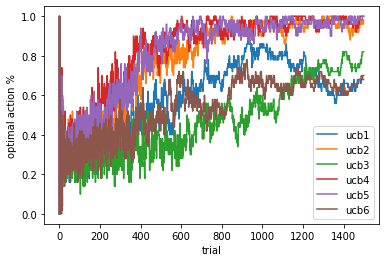

In [54]:
k = 0
for i in astaru:
  opta = i
  opta_per = optimal_action_ratio(datasu[k], opta)
  draw_list(opta_per, 'trial', 'optimal action %', 'ucb'+str(k+1))
  k+=1

In [40]:
p, l = find_best_path(qsumu, astaru, pathes)
print('best path: ', p, ' mean latency:', l, ' actions: ', 6*1500 )

best path:  [0, 1, 5, 9, 12]  mean latency: 18.619356242172724  actions:  9000


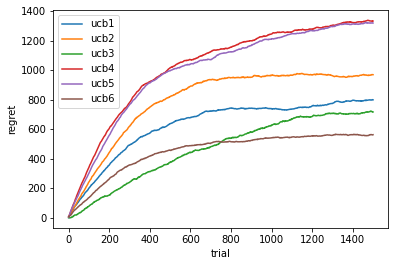

In [34]:
for i in range(len(qsumu)):
  mean_regret = np.mean(np.array(regret(datasu[i], qsumu[i])), axis=0)
  # print(np.argmin(np.abs(np.diff(mean_regret[1000:])))+1000)
  draw_list(mean_regret, 'trial', 'regret', 'ucb'+str(i+1))

In [43]:
class ThompsonAgent(AgentBase):
    def __init__(self, id, environment):
        super(ThompsonAgent, self).__init__(id, environment)
        self.act_num = self.environment.available_actions()
        self.p0 = 0.0001  # precision
        self.m0 = 0       # mean
        self.actions_estimation = dict(zip(range(self.act_num),\
                                           [[self.m0, self.p0] for i in range(self.act_num)]))
        self.data_list = [[] for i in range(self.act_num)]
        self.length = 0
        self.trial = {}
        print(self.actions_estimation)
    
    def reset(self):
        self.actions_estimation = dict(zip(range(self.act_num),\
                                           [[self.m0, self.p0] for i in range(self.act_num)]))
        self.length = 0
        self.trial = {}
        print(self.actions_estimation)

    def update_estimation(self, action, r):
        self.data_list[action].append(r)
        pers_r = 0
        if len(self.data_list[action]) == 1:
          pers_r = 1
        else:
          pers_r = 1/np.var(self.data_list[action], ddof=1)
        self.actions_estimation[action][0] +=\
          ((pers_r/float(pers_r+self.actions_estimation[action][1]))*(r-self.actions_estimation[action][0]))
        self.actions_estimation[action][1] += pers_r

        self.trial[self.length] = (action, r)
        self.length += 1

    def select_action(self):
        sample = {}
        for i in self.actions_estimation.keys():
          sample[i] = np.random.normal(\
                            self.actions_estimation[i][0],np.sqrt(1/self.actions_estimation[i][1]),1)
        return max(sample.items(), key=operator.itemgetter(1))[0]

    def get_stat(self):
        return self.trial

    def get_best_action(self):
        index = self.select_action()
        return (index,self.actions_estimation[index][0])

    def take_action(self) -> (object, float, bool, object):
        action = self.select_action()
        obs, r, d, i = self.environment.step(action)
        self.update_estimation(action, r)
        print(obs, r, d, i)
        self.environment.render()
        return obs, r, d, i

In [44]:
def run_thompson(pathes):

  datas = []
  qsum = [0 for i in range(len(pathes))]
  astar = [0 for i in range(len(pathes))]

  k = 0

  for p in pathes:
    rewards = None
    if k <3:
      print(p)
      rewards = [PathReward([mean_map[link_color[(i[j],i[j+1])]] for j in range(len(i)-1)],\
                          [std_map[link_color[(i[j],i[j+1])]] for j in range(len(i)-1)],\
                          [pis[i[j]-1] for j in range(1,len(i))]) for i in p]
    if k >= 3:
      rewards = [PathReward([mean_map[link_color[(i[j],i[j+1])]] for j in range(len(i)-1)],\
                        [std_map[link_color[(i[j],i[j+1])]] for j in range(len(i)-1)],\
                        [pis[i[j]-1] for j in range(1,len(i)-1)]) for i in p]
    env = MutliArmedBanditEnvironment(rewards, 5000, '1')
    agent = ThompsonAgent('1', env)
    qsum_t = 0
    data = []
    for run in range(50):
      for step in range(1500):
          agent.take_action()
      data.append(agent.get_stat())
      qsum[k] += agent.get_best_action()[1]
      astar[k] = agent.get_best_action()[0]
      env.reset()
      agent.reset()
    qsum[k] /= 50
    datas.append(data)
    k+=1
  print(qsum)
  return datas, qsum, astar
  # return datas, astar

In [45]:
datast, qsumt, astart = run_thompson(pathes)

Streaming output truncated to the last 5000 lines.
502:	action=2
{} -13.419346564712766 False {}
503:	action=1
{} -10.198564049463156 False {}
504:	action=1
{} -16.48567848564904 False {}
505:	action=1
{} -12.149449348678738 False {}
506:	action=1
{} -10.959616521626682 False {}
507:	action=1
{} -7.752166317773145 False {}
508:	action=2
{} -5.750200748276471 False {}
509:	action=2
{} -6.121429997065084 False {}
510:	action=1
{} -5.234072269295233 False {}
511:	action=2
{} -7.628644184791318 False {}
512:	action=2
{} -9.975591794229592 False {}
513:	action=2
{} -4.768843972480278 False {}
514:	action=2
{} -6.70314014555732 False {}
515:	action=2
{} -19.14125725777471 False {}
516:	action=1
{} -12.862792139021188 False {}
517:	action=1
{} -10.722311504280864 False {}
518:	action=2
{} -10.902054797540071 False {}
519:	action=2
{} -11.307780821036403 False {}
520:	action=1
{} -7.7004664613015485 False {}
521:	action=2
{} -7.408829884091878 False {}
522:	action=2
{} -1.8040765811187827 Fals

In [46]:
p, l = find_best_path(qsumt, astart, pathes)
print('best path: ', p, ' mean latency:', l, ' actions: ', 6*1500 )

best path:  [0, 1, 5, 9, 12]  mean latency: 18.621562985580674  actions:  9000


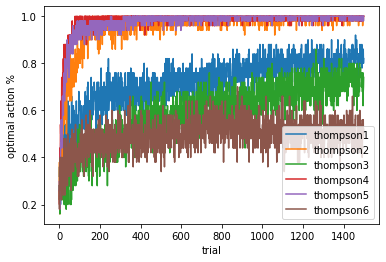

In [55]:
k = 0
for i in astart:
  opta = i
  opta_per = optimal_action_ratio(datast[k], opta)
  draw_list(opta_per, 'trial', 'optimal action %', 'thompson'+str(k+1))
  k+=1

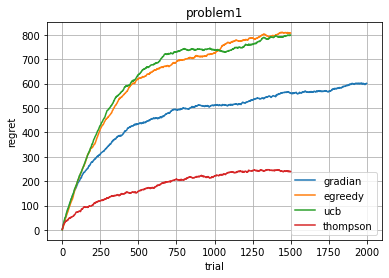

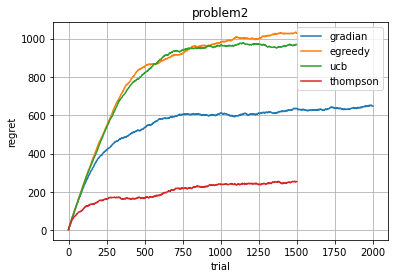

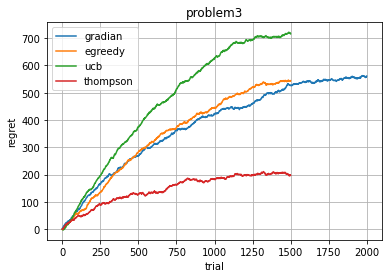

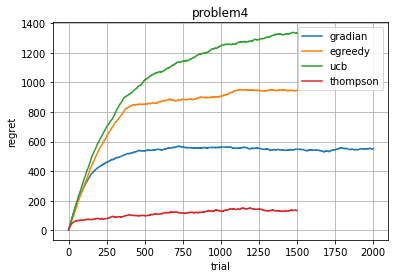

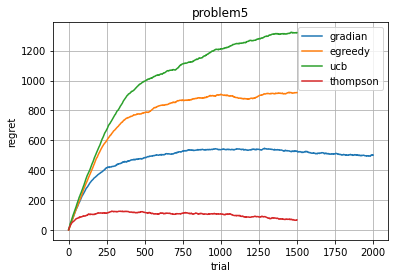

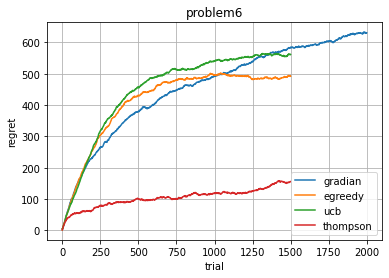

In [48]:
for i in range(len(pathes)):
  mean_regret = np.mean(np.array(regret(datasg[i], qsumg[i])), axis=0)
  draw_list(mean_regret, 'trial', 'regret', 'gradian')
  mean_regret = np.mean(np.array(regret(datas[i], qsum[i])), axis=0)
  draw_list(mean_regret, 'trial', 'regret', 'egreedy')
  mean_regret = np.mean(np.array(regret(datasu[i], qsumu[i])), axis=0)
  draw_list(mean_regret, 'trial', 'regret', 'ucb')
  mean_regret = np.mean(np.array(regret(datast[i], qsumt[i])), axis=0)
  draw_list(mean_regret, 'trial', 'regret', 'thompson')
  plt.title('problem'+str(i+1))
  plt.grid()
  plt.show()